# Implementation of the Moho inversion algorithm

This notebook presents a Python class that implements the proposed method. We'll use the [inverse problems framework](http://www.fatiando.org/api/inversion.html) of the library [Fatiando a Terra](http://www.fatiando.org). The class `MohoGravityInvSpherical` is defined in the [`mohoinv.py`](mohoinv.py) file.

## The Moho inversion method

Using the `fatiando.inversion` API. The inversion will be based on the method of Silva et al. 2014 to speedup computations. Silva et al. 2014 modify Bott's (1960) method. They show that Bott's method is a special case of the Gauss-Newton method

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[\mathbf{A}^T \mathbf{A}\right]^{-1} \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)]
$$

but with the Jacobian $\mathbf{A}$ approximated by a diagonal with 

$$
A_{ii} = 2\pi G \rho
$$. 

Silva et al. also implement a step size modification algorithm similar to Marquardt's method to speed up convergence.
 
Silva et al. don't actually solve the Gauss-Newton iterations to avoid the linear systems. However, all matrices involved are (very) sparse. The `fatiando.inversion` package can handle `scipy.sparse` matrices transparently so we'll use the standard inversion classes with sparse matrices for our implementation.

The step size modification algorithm can then be substituted by the Levemberg-Marquardt algorithm because solving the sparse linear systems is trivial and very fast.

## Bott's method as a special case of the Steepest Descent method

We can further expand the method to cast Bott's method as a special case of the Steepest Descent algorithm. 
The step in the Steepest Descent method is

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - \nabla \Theta(\mathbf{p}^k) 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
$$

Bott's method would then be the special case of $\mathbf{A}$ being a diagonal matrix with 

$$
A_{ii} = \frac{1}{2(2 \pi G \rho_i)}.
$$

## Package imports

In [1]:
# Insert plots into the notebook
%matplotlib inline

In [2]:
from __future__ import division, unicode_literals
import numpy as np
import multiprocessing
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn  # Makes the default style of the plots nicer

Load the required modules from Fatiando a Terra and show the specific version of the library used.

In [3]:
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando

In [4]:
print("Using Fatiando a Terra version: {}".format(fatiando.__version__))

Using Fatiando a Terra version: 0.3-429-g3c4953c


In [5]:
from mohoinv import TesseroidRelief, MohoGravityInvSpherical, make_mesh

Get the number of cores in the computer to run the forward modeling in parallel.

In [6]:
ncpu = multiprocessing.cpu_count()
ncpu

4

## Test the class on simple synthetic data

We can test and show how the class works on some simple synthetic data. We'll use the example model from the [tesseroid-relief-example.ipynb](tesseroid-relief-example.ipynb) notebook.

First, make the model of the Moho.

In [7]:
# shape is nlat, nlon = the number of points in the grid
shape = (30, 30)
# Make a regular grid inside an area = (s, n, w, e)
area = (20, 60, -40, 40)
lat, lon, h = gridder.regular(area, shape, z=250e3)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.15
reference = -35e3
relief = 10e3*np.sin(1.5*f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [8]:
model = make_mesh(area, shape, relief, reference)
model.addprop('density', density)

In [9]:
def plot_result_3d(moho, fname):
    "Plot the tesseroid model in 3D."
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

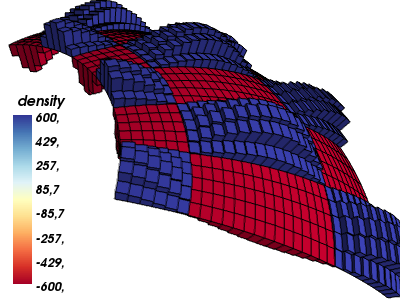

In [10]:
plot_result_3d(model, 'simple-synthetic-model.png')

Now, generate some synthetic data by forward modeling.

In [11]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)

/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


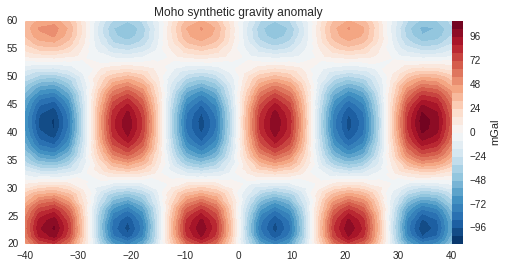

In [12]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

### Using the Gauss-Newton formulation

For this test, we'll use a mesh with the same dimensions and the original model.

In [15]:
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)

Create the solver object.

In [16]:
solver = MohoGravityInvSpherical(lat, lon, h, gz, mesh, njobs=ncpu)

Configure the optimization method to Gauss-Newton and set the initial estimate.

In [17]:
initial = np.ones(solver.nparams)*(mesh.reference - 30e3)
solver.config('newton', initial=initial, tol=0.2, maxit=10)

Run the inversion and time the computation.

In [18]:
%time solver.fit()

CPU times: user 48 ms, sys: 32 ms, total: 80 ms
Wall time: 8.11 s


/home/leo/src/fatiando/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


Plot the RMS error (Root Mean Square) per iteration to get an idea of the convergence of the method.

In [19]:
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)

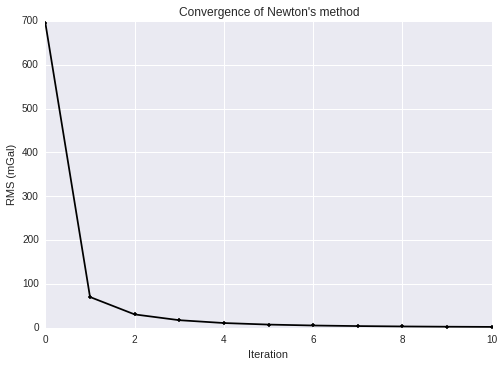

In [22]:
plt.figure()
ax = plt.subplot(111)
ax.set_title('Convergence of {}'.format(solver.stats_['method']))
ax.plot(rms, '.k-')
ax.set_ylabel('RMS (mGal)')
ax.set_xlabel('Iteration')

Plot the data misfit and residuals

In [23]:
predicted = solver.predicted()
residuals = solver.residuals()

/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


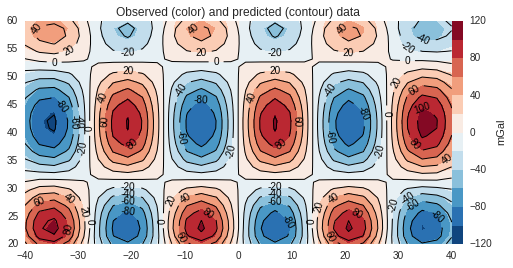

In [24]:
plt.figure(figsize=(9, 4))
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')
mpl.contour(lon, lat, predicted, shape, levels)
plt.title('Observed (color) and predicted (contour) data')

Mean: 0.214036548333   std: 2.02563704196


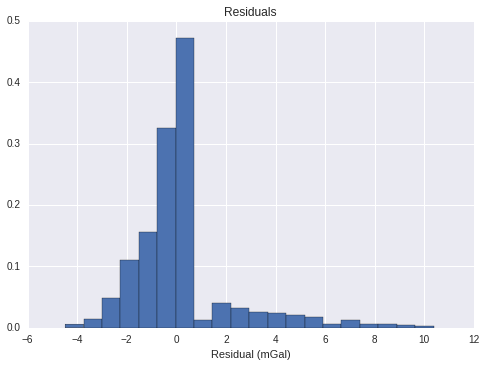

In [26]:
plt.title('Residuals')
plt.hist(residuals, bins=20, normed=True)
plt.xlabel('Residual (mGal)')
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

Map the estimated Moho depth.

In [27]:
moho = solver.estimate_

(19.310344827586206, 59.310344827586206)

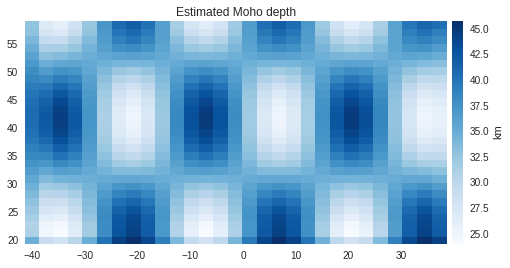

In [28]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.pcolormesh(moho.lons, moho.lats, -0.001*moho.relief.reshape(moho.shape), cmap='Blues')
plt.colorbar(pad=0.01).set_label('km')
plt.xlim(moho.lons.min(), moho.lons.max())
plt.ylim(moho.lats.min(), moho.lats.max())

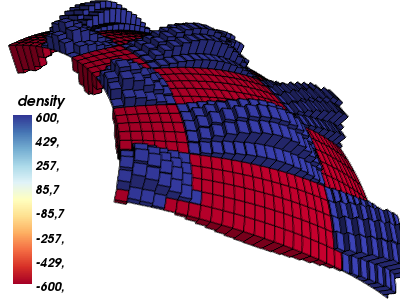

In [29]:
plot_result_3d(moho, 'mohoinv-example.png')

### Using the Steepest Descent formulation

We can re-use the same `solver` object created above to run using Steepest Descent.

In [30]:
solver.config('steepest', initial=initial, tol=0.2, maxit=10, linesearch=False)

In [31]:
%time solver.fit()

CPU times: user 24 ms, sys: 60 ms, total: 84 ms
Wall time: 7.88 s


/home/leo/src/fatiando/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


Make the same plots as above.

In [32]:
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)

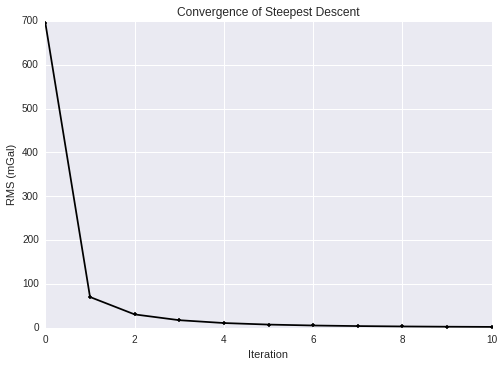

In [34]:
plt.figure()
ax = plt.subplot(111)
ax.set_title('Convergence of {}'.format(solver.stats_['method']))
ax.plot(rms, '.k-')
ax.set_ylabel('RMS (mGal)')
ax.set_xlabel('Iteration')

In [36]:
moho = solver.estimate_

(19.310344827586206, 59.310344827586206)

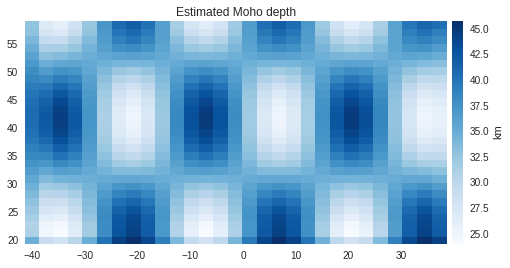

In [37]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.pcolormesh(moho.lons, moho.lats, -0.001*moho.relief.reshape(moho.shape), cmap='Blues')
plt.colorbar(pad=0.01).set_label('km')
plt.xlim(moho.lons.min(), moho.lons.max())
plt.ylim(moho.lats.min(), moho.lats.max())

The computation time is roughly the same because solving the sparse systems is very cheap.